#**Support Vector Machine - Regression (Scratch)**

###**Kernels in SVM:**
- **Linear:** For linearly separable data.
- **Polynomial:** For polynomial relationships in data.
- **RBF (Gaussian):** For highly non-linear data, most popular in real-world applications.
- **Sigmoid:** Similar to neural network activations, used for non-linear relationships.
- **Custom:** For special use cases with specific domain knowledge.

###**Loss Functions of SVM:**
- **Epsilon-Insensitive Loss** is the standard for SVR, particularly useful for handling noise.
- **Squared Loss** is more common in traditional regression but can lead to models sensitive to outliers.
- **Huber Loss and Log-Cosh Loss** provide robust alternatives, striking a balance between sensitivity and smoothness.
- **Absolute Loss** is useful when outliers are a significant concern.

**Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.datasets import load_diabetes, load_iris, fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import MaxAbsScaler, PowerTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import precision_score, recall_score, f1_score, explained_variance_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

**Code**

In [2]:
class SVR:
    def __init__(self, kernel='linear', C=1.0, loss='epsilon_insensitive', epsilon=0.1, degree=3, gamma='scale', n_epochs=10, learning_rate=0.001):
        self.kernel = kernel
        self.C = C
        self.loss_function = loss
        self.epsilon = epsilon
        self.degree = degree
        self.gamma = gamma
        self.n_epochs = n_epochs
        self.learning_rate = learning_rate
        self.models = []
        self.X_train = None
        self.y_train = None

    def _kernel(self, X1, X2):
        if self.kernel == 'linear':
            return np.dot(X1, X2.T)
        elif self.kernel == 'polynomial':
            return (np.dot(X1, X2.T) + 1) ** self.degree
        elif self.kernel == 'rbf':
            if isinstance(self.gamma, str) and self.gamma == 'scale':
                self.gamma = 1 / X1.shape[1]  # Default scale
            diff = X1[:, np.newaxis, :] - X2[np.newaxis, :, :]
            return np.exp(-self.gamma * np.sum(diff ** 2, axis=2))
        else:
            raise ValueError("Unknown kernel type.")

    def _epsilon_insensitive_loss(self, y_true, y_pred):
        return np.maximum(0, np.abs(y_true - y_pred) - self.epsilon)

    def _squared_loss(self, y_true, y_pred):
        return 0.5 * (y_true - y_pred) ** 2

    def _absolute_loss(self, y_true, y_pred):
        return np.abs(y_true - y_pred)

    def _huber_loss(self, y_true, y_pred):
        delta = 1.0  # Delta can be a hyperparameter
        error = y_true - y_pred
        is_small_error = np.abs(error) <= delta
        return np.where(is_small_error, 0.5 * error ** 2, delta * (np.abs(error) - 0.5 * delta))

    def _log_cosh_loss(self, y_true, y_pred):
        error = y_true - y_pred
        return np.log(np.cosh(error))

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y  # Store training labels
        self.models = []

        # Compute kernel matrix for all training data once
        K_full = self._kernel(X, X)

        # Initialize alpha and bias
        alpha = np.zeros(X.shape[0])
        b = 0

        for epoch in range(self.n_epochs):
            epoch_loss = 0

            # Compute the prediction for the current model
            y_pred = np.sum(alpha[:, np.newaxis] * K_full, axis=0) - b

            # Select the appropriate loss function
            if self.loss_function == 'epsilon_insensitive':
                loss = self._epsilon_insensitive_loss(y, y_pred)
            elif self.loss_function == 'squared':
                loss = self._squared_loss(y, y_pred)
            elif self.loss_function == 'absolute':
                loss = self._absolute_loss(y, y_pred)
            elif self.loss_function == 'huber':
                loss = self._huber_loss(y, y_pred)
            elif self.loss_function == 'log_cosh':
                loss = self._log_cosh_loss(y, y_pred)
            else:
                raise ValueError("Unknown loss function.")

            epoch_loss = np.mean(loss)  # Averaging the loss per sample

            # Update alpha and b where there is a margin violation
            mask = loss > 0
            alpha[mask] += self.learning_rate * self.C * (y[mask] - y_pred[mask])
            b -= self.learning_rate * self.C * np.sum(y[mask] - y_pred[mask])

            self.models.append((alpha.copy(), b))  # Append a copy of the parameters

            # Print average loss for each epoch
            print(f"Epoch {epoch + 1}/{self.n_epochs}, Average Loss: {epoch_loss:.2f}")

    def predict(self, X):
        K_test = self._kernel(X, self.X_train)  # Compute kernel matrix for test data
        alpha, b = self.models[-1]  # Use the last trained model's parameters
        y_pred = np.dot(K_test, alpha) - b  # Make predictions using the kernel
        return y_pred

**Load Dataset**

In [3]:
# Create dataset
X = np.random.rand(500, 1) * 10  # Training data
y = 2 * X.flatten() + np.random.randn(500) * 2  # Linear relation with noise

In [4]:
print(X[:5])
print(y[:5])

[[1.79332921]
 [1.89830432]
 [0.61985233]
 [7.32696744]
 [1.41623994]]
[ 6.19264607  4.91777617  0.41657727 12.34171317  2.54141408]


In [5]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((350, 1), (150, 1), (350,), (150,))

In [6]:
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
# Train
svr = SVR(kernel='linear', C=1.0, epsilon=0.1, n_epochs=10, learning_rate=0.001, loss='epsilon_insensitive')
svr.fit(X_train, y_train)

Epoch 1/10, Average Loss: 9.71
Epoch 2/10, Average Loss: 6.37
Epoch 3/10, Average Loss: 4.23
Epoch 4/10, Average Loss: 2.92
Epoch 5/10, Average Loss: 2.18
Epoch 6/10, Average Loss: 1.80
Epoch 7/10, Average Loss: 1.60
Epoch 8/10, Average Loss: 1.51
Epoch 9/10, Average Loss: 1.47
Epoch 10/10, Average Loss: 1.45


In [8]:
# Make predictions
y_pred = svr.predict(X_test)
print(y_pred[:5])

[10.51605997  7.83066468 18.67285339 13.83674999 10.5757094 ]


**Visualize**

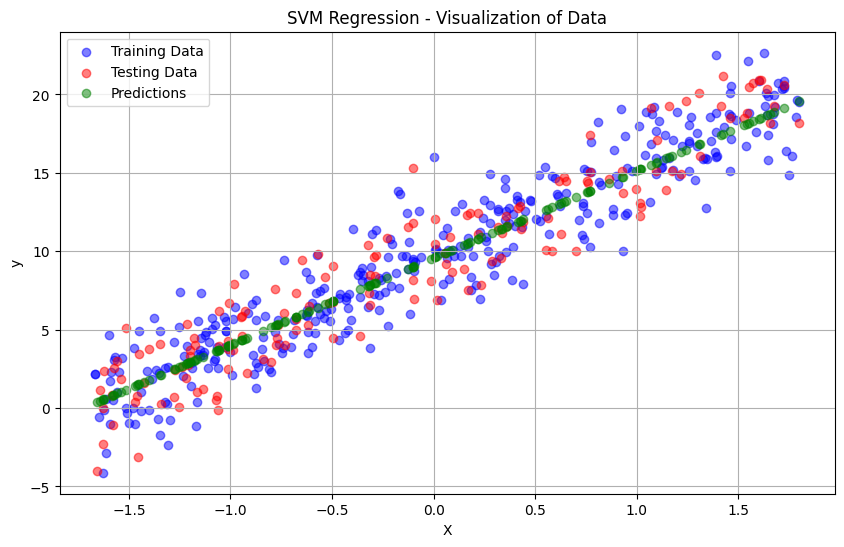

In [9]:
# Visualization of all data
def visualize_all_data(X_train, y_train, X_test, y_test, y_pred):
    plt.figure(figsize=(10, 6))

    # Plot training data
    plt.scatter(X_train, y_train, color='blue', label='Training Data', alpha=0.5)
    # Plot testing data
    plt.scatter(X_test, y_test, color='red', label='Testing Data', alpha=0.5)
    # Plot predictions
    plt.scatter(X_test, y_pred, color='green', label='Predictions', alpha=0.5)

    plt.title('SVM Regression - Visualization of Data')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend()
    plt.grid()
    plt.show()

# Visualize all data after predictions
visualize_all_data(X_train, y_train, X_test, y_test, y_pred)

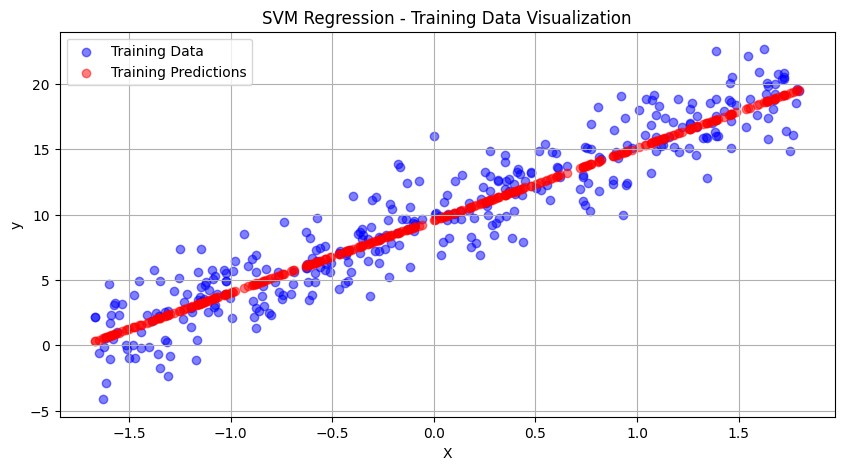

In [10]:
# Visualize Training Data
def visualize_training(X_train, y_train, svr):
    plt.figure(figsize=(10, 5))
    plt.scatter(X_train, y_train, color='blue', label='Training Data', alpha=0.5)

    # Plot predictions for training data
    y_train_pred = svr.predict(X_train)  # Use the svr instance to predict
    plt.scatter(X_train, y_train_pred, color='red', label='Training Predictions', alpha=0.5)

    plt.title('SVM Regression - Training Data Visualization')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend()
    plt.grid()
    plt.show()

# Visualize Training Data
visualize_training(X_train, y_train, svr)

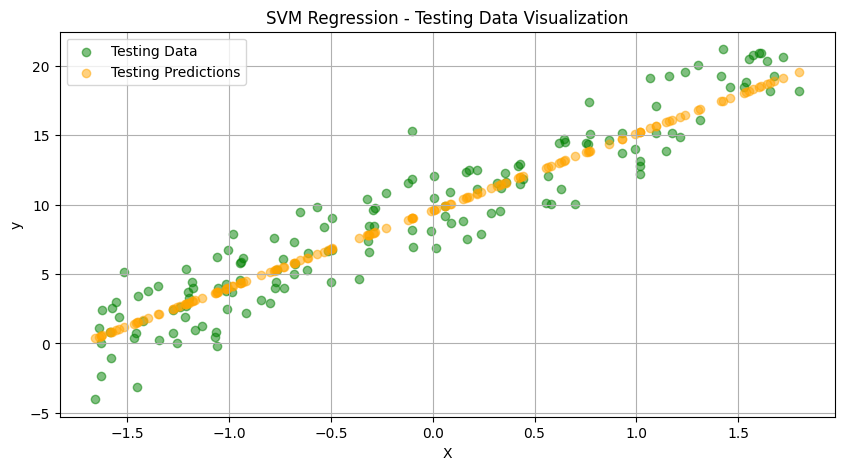

In [11]:
# Visualize Testing Data
def visualize_testing(X_test, y_test):
    plt.figure(figsize=(10, 5))
    plt.scatter(X_test, y_test, color='green', label='Testing Data', alpha=0.5)

    # Plot predictions for testing data
    y_test_pred = svr.predict(X_test)
    plt.scatter(X_test, y_test_pred, color='orange', label='Testing Predictions', alpha=0.5)

    plt.title('SVM Regression - Testing Data Visualization')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend()
    plt.grid()
    plt.show()

# Visualize Testing Data
visualize_testing(X_test, y_test)